# 示例：剩余使用寿命预测

In [1]:
from rulframework.data.FeatureExtractor import FeatureExtractor
from rulframework.data.labeler.RulLabeler import RulLabeler
from rulframework.data.loader.bearing.XJTULoader import XJTULoader
from rulframework.data.processor.RMSProcessor import RMSProcessor
from rulframework.metric.end2end.NASAScore import NASAScore
from rulframework.metric.end2end.PHM2012Score import PHM2012Score
from rulframework.metric.end2end.PercentError import PercentError
from rulframework.model.pytorch.PytorchModel import PytorchModel
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.model.pytorch.basic.CNN import CNN
from rulframework.metric.Evaluator import Evaluator
from rulframework.metric.end2end.MAE import MAE
from rulframework.metric.end2end.MSE import MSE
from rulframework.metric.end2end.RMSE import RMSE
from rulframework.util.Plotter import Plotter

# 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, data_loader.continuum)

DEBUG - 15:02:51 >> 
<< Root directory of dataset: D:\data\dataset\XJTU-SY_Bearing_Datasets
	Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	Bearing3_1, location: D:\data\dataset\XJTU-SY_Bearing_Dat

# 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader("Bearing1_3", 'Horizontal Vibration')
feature_extractor(bearing)
stage_calculator(bearing)

INFO - 15:02:52 >> Loading data entity: Bearing1_3
INFO - 15:02:54 >> Successfully loaded data entity: Bearing1_3


# 生成训练数据

In [4]:
generator = RulLabeler(2048, is_from_fpt=False, is_rectified=True, time_ratio=60)
data_set = generator(bearing)
train_set, test_set = data_set.split(0.7)

# 定义模型并训练

INFO - 15:02:55 >> 
<< Successfully initialized model:
	device: cuda
	dtype: torch.float32
INFO - 15:02:55 >> Start training model...
DEBUG - 15:02:55 >> Epoch 1/10, Loss: 0.1237551818
DEBUG - 15:02:55 >> Epoch 2/10, Loss: 0.0080573022
DEBUG - 15:02:55 >> Epoch 3/10, Loss: 0.0048640060
DEBUG - 15:02:55 >> Epoch 4/10, Loss: 0.0034345968
DEBUG - 15:02:55 >> Epoch 5/10, Loss: 0.0027366384
DEBUG - 15:02:55 >> Epoch 6/10, Loss: 0.0023720970
DEBUG - 15:02:55 >> Epoch 7/10, Loss: 0.0020557160
DEBUG - 15:02:56 >> Epoch 8/10, Loss: 0.0020639813
DEBUG - 15:02:56 >> Epoch 9/10, Loss: 0.0018316568
DEBUG - 15:02:56 >> Epoch 10/10, Loss: 0.0017247541
INFO - 15:02:56 >> Model training completed!!!


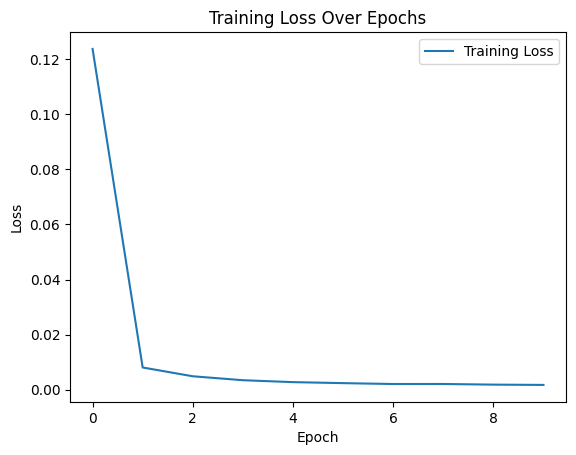

'Training Loss Over Epochs'

In [5]:
model = PytorchModel(CNN(2048, 1))
model.train(train_set, 10, weight_decay=0.01)
Plotter.loss(model)

# 做出预测

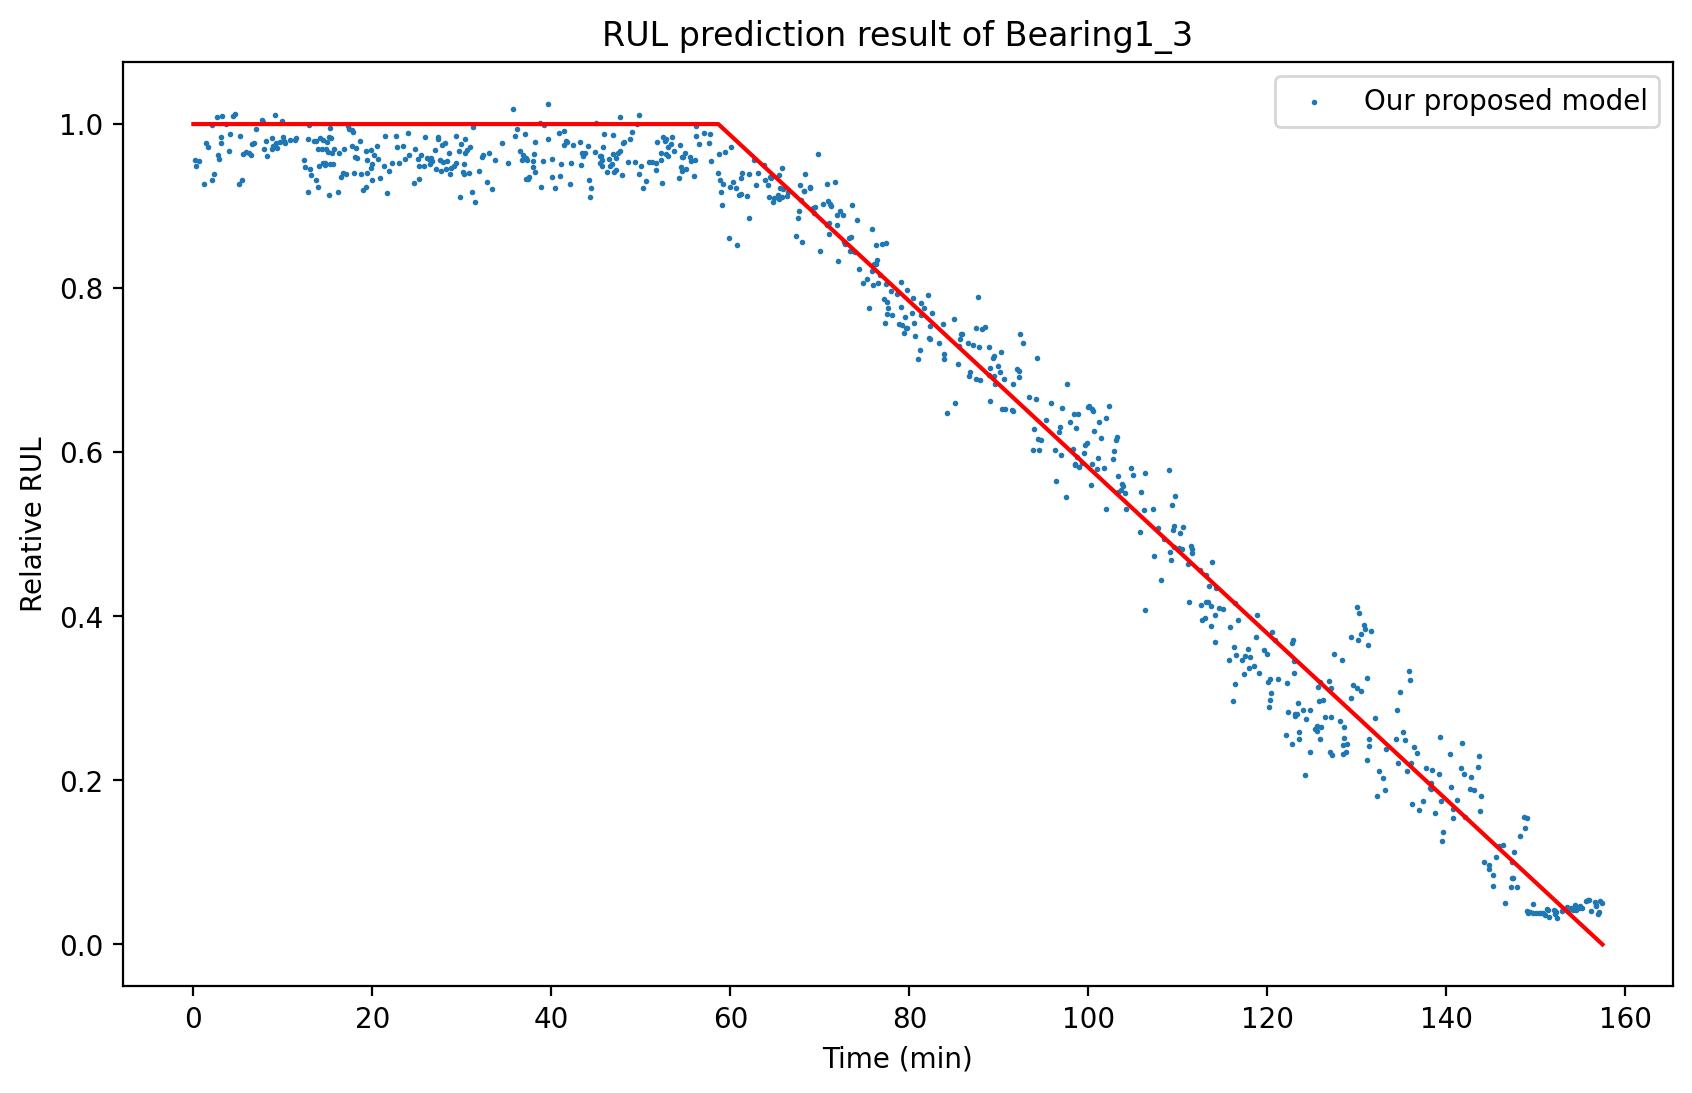

'RUL prediction result of Bearing1_3'

In [6]:
result = model.test(test_set)
Plotter.rul_end2end(test_set, result, label_x='Time (min)', label_y='Relative RUL')

# 预测结果评价

In [7]:
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), NASAScore())
evaluator(test_set, result)

INFO - 15:02:56 >> 
<< Performance evaluation of Bearing1_3:
	MAE: 0.0362
	MSE: 0.0019
	RMSE: 0.0441
	Percent Error: -1.98%
	PHM2012 Score: 0.7224
	NASA Score: 2.2949


{'MAE': '0.0362',
 'MSE': '0.0019',
 'RMSE': '0.0441',
 'Percent Error': '-1.98%',
 'PHM2012 Score': '0.7224',
 'NASA Score': '2.2949'}